In [84]:
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans

In [85]:
df = pd.read_csv('./downloads/movies.csv')
df['genres'] = [i.split('|') for i in df['genres']]
all_categories = set(cat for sublist in df['genres'] for cat in sublist)
print(all_categories)

#Encoding Genres
for category in all_categories:
    df[category] = df['genres'].apply(lambda x: 1 if category in x else 0)
df = df.drop('genres', axis=1)

features = df.drop(['movieId', 'title'], axis=1)
df.head()

#Movie Recommenders ( I love you Sam Altman )
def recommend_movies_kmeans(movie_title, df, features, top_n=5):
    if movie_title not in df['title'].values:
        raise ValueError(f"Movie '{movie_title}' not found in the dataset.")
    
    # Find the index of the input movie
    movie_idx = df[df['title'] == movie_title].index[0]
    
    # Ensure movie_features is correctly aligned with the features DataFrame
    movie_features = features.loc[movie_idx]  # Use .loc instead of relying on positional indexing
    
    # Find the cluster and features of the input movie
    movie_cluster = df.loc[movie_idx, 'cluster']
    
    # Get movies from the same cluster
    similar_movies = df[df['cluster'] == movie_cluster].copy()
    
    # Calculate distances from input movie to all other movies in the cluster
    distances = []
    for i in similar_movies.index:
        if df.loc[i, 'title'] != movie_title:  # Exclude the input movie
            distance = np.linalg.norm(features.loc[i] - movie_features)
            distances.append((df.loc[i, 'title'], distance))
    
    # Sort by distance and get top_n recommendations
    recommendations = sorted(distances, key=lambda x: x[1])[:top_n]
    
    # Return recommendations as DataFrame
    return pd.DataFrame(recommendations, columns=['title', 'distance'])

{'Comedy', 'Thriller', 'Musical', 'Sci-Fi', 'Drama', 'Romance', 'War', 'Fantasy', 'IMAX', 'Adventure', 'Children', 'Animation', 'Action', 'Horror', 'Western', 'Crime', '(no genres listed)', 'Documentary', 'Film-Noir', 'Mystery'}


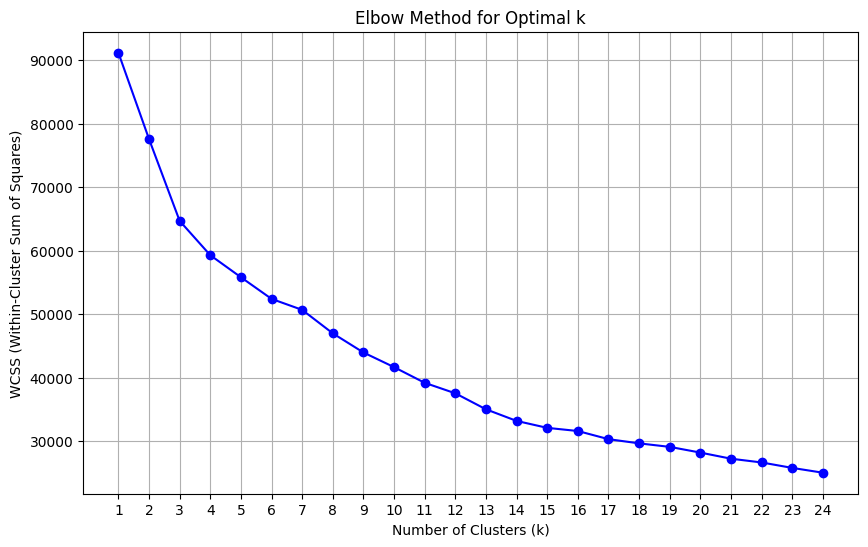

In [86]:
# K-MEANS
wcss = []
for k in range(1, 25):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(features)
    wcss.append(kmeans.inertia_)  # inertia_ is the WCSS value

# Plotting the elbow graph

plt.figure(figsize=(10, 6))
plt.plot(range(1, 25), wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.xticks(range(1, 25))
plt.grid(True)
plt.show()


In [87]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=1)
df['cluster'] = kmeans.fit_predict(features)

recommendations = recommend_movies_kmeans('Interstellar (2014)', df, features)
print(recommendations)


                                   title  distance
0  2010: The Year We Make Contact (1984)       1.0
1                          Meteor (1979)       1.0
2     Sticky Fingers of Time, The (1997)       1.0
3              Flying Saucer, The (1950)       1.0
4        It Came from Outer Space (1953)       1.0


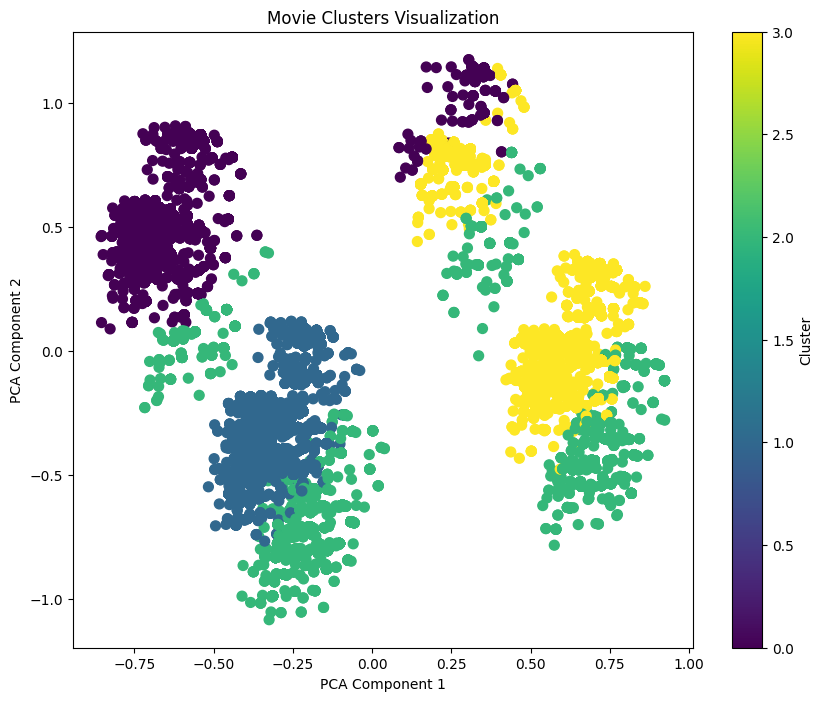

In [88]:
#Visualisation for reference by GPT
# Reduce dimensions to 2 for visualization (using PCA)
pca = PCA(n_components=2)
pca_features = pca.fit_transform(df.drop(['movieId', 'title', 'cluster'], axis=1))  # Drop non-numeric columns
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], c=df['cluster'], cmap='viridis', s=50)
plt.colorbar(scatter, label='Cluster')
plt.title('Movie Clusters Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [89]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features) 

# Function to apply DBSCAN on scaled features
def apply_dbscan(scaled_features, eps=0.15, min_samples=4):
    # DBSCAN clustering on scaled features
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    df['cluster'] = dbscan.fit_predict(scaled_features)
    return df
df = apply_dbscan(scaled_features)

#Love you altman again
def recommend_movies_dbscan(movie_title, df, scaled_features, top_n=5, eps=0.5, min_samples=5):
    if movie_title not in df['title'].values:
        raise ValueError(f"Movie '{movie_title}' not found in the dataset.")
    
    if 'cluster' not in df.columns:
        df = apply_dbscan(scaled_features, eps, min_samples)  # Ensure clustering has been applied
    
    # Find the index of the input movie
    movie_idx = df[df['title'] == movie_title].index[0]
    # Check if the movie is in a valid cluster or is noise (-1)
    movie_cluster = df.loc[movie_idx, 'cluster']
    if movie_cluster == -1:
        raise ValueError(f"Movie '{movie_title}' is considered noise by DBSCAN.")
    # Get the features of the input movie from scaled_features
    movie_features = scaled_features[movie_idx]
    # Get movies from the same cluster
    similar_movies = df[df['cluster'] == movie_cluster].copy()
    # Calculate distances from the input movie to all other movies in the cluster
    distances = []
    for i in similar_movies.index:
        if df.loc[i, 'title'] != movie_title:  # Exclude the input movie
            distance = np.linalg.norm(scaled_features[i] - movie_features)
            distances.append((df.loc[i, 'title'], distance))
    # Sort by distance and get top_n recommendations
    recommendations = sorted(distances, key=lambda x: x[1])[:top_n]
    # Return recommendations as DataFrame
    return pd.DataFrame(recommendations, columns=['title', 'distance'])

recommendations = recommend_movies_dbscan('Shutter Island (2010)', df, scaled_features, top_n=5)
print(recommendations)


                         title  distance
0           Client, The (1994)       0.0
1         39 Steps, The (1935)       0.0
2             Game, The (1997)       0.0
3  The Devil's Advocate (1997)       0.0
4              Insomnia (1997)       0.0


In [90]:
noise_movies = df[df['cluster'] == -1]
print(f"Number of noise movies: {len(noise_movies)}")
print(df['cluster'].value_counts())

Number of noise movies: 1526
cluster
11     9056
4      5674
537    5062
38     4731
37     2386
       ... 
198       4
284       4
375       4
208       4
590       4
Name: count, Length: 592, dtype: int64
